In [1]:
import numpy as np
import sklearn
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, brier_score_loss
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

In [3]:
# Set random seed for reproducibility
np.random.seed(42)

# Generate synthetic dataset
def generate_synthetic_data(n_samples=1000, n_features=10):
    """
    Generate synthetic binary classification dataset.
    
    Parameters:
    - n_samples: Number of samples to generate
    - n_features: Number of features
    
    Returns:
    - X: Feature matrix
    - y: Binary labels
    """
    X = np.random.rand(n_samples, n_features)
    # Create binary labels based on simple threshold rule
    y = (X[:, 0] + X[:, 1] > 1).astype(int)
    return X, y

# Generate data and split into train/test sets
X, y = generate_synthetic_data(n_samples=1000, n_features=10)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training samples: {X_train.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")
print(f"Positive class ratio: {np.mean(y_train):.3f}")

Training samples: 800
Test samples: 200
Positive class ratio: 0.477


In [4]:
# Train base Random Forest classifier
rf_classifier = RandomForestClassifier(
    n_estimators=100, 
    random_state=42, 
    max_depth=5
)
rf_classifier.fit(X_train, y_train)

# Get uncalibrated probabilities
rf_probs_uncalibrated = rf_classifier.predict_proba(X_test)[:, 1]

# Apply calibration using Platt scaling (sigmoid)
calibrated_clf_platt = CalibratedClassifierCV(
    rf_classifier, 
    method='sigmoid', 
    cv=3
)
calibrated_clf_platt.fit(X_train, y_train)
rf_probs_platt = calibrated_clf_platt.predict_proba(X_test)[:, 1]

# Apply calibration using isotonic regression
calibrated_clf_isotonic = CalibratedClassifierCV(
    rf_classifier, 
    method='isotonic', 
    cv=3
)
calibrated_clf_isotonic.fit(X_train, y_train)
rf_probs_isotonic = calibrated_clf_isotonic.predict_proba(X_test)[:, 1]

# Evaluate calibration performance
print("Calibration Performance Metrics:")
print(f"Uncalibrated - Log Loss: {log_loss(y_test, rf_probs_uncalibrated):.4f}")
print(f"Uncalibrated - Brier Score: {brier_score_loss(y_test, rf_probs_uncalibrated):.4f}")
print(f"Platt Scaling - Log Loss: {log_loss(y_test, rf_probs_platt):.4f}")
print(f"Platt Scaling - Brier Score: {brier_score_loss(y_test, rf_probs_platt):.4f}")
print(f"Isotonic Regression - Log Loss: {log_loss(y_test, rf_probs_isotonic):.4f}")
print(f"Isotonic Regression - Brier Score: {brier_score_loss(y_test, rf_probs_isotonic):.4f}")

Calibration Performance Metrics:
Uncalibrated - Log Loss: 0.2824
Uncalibrated - Brier Score: 0.0718
Platt Scaling - Log Loss: 0.1285
Platt Scaling - Brier Score: 0.0358
Isotonic Regression - Log Loss: 0.1131
Isotonic Regression - Brier Score: 0.0338


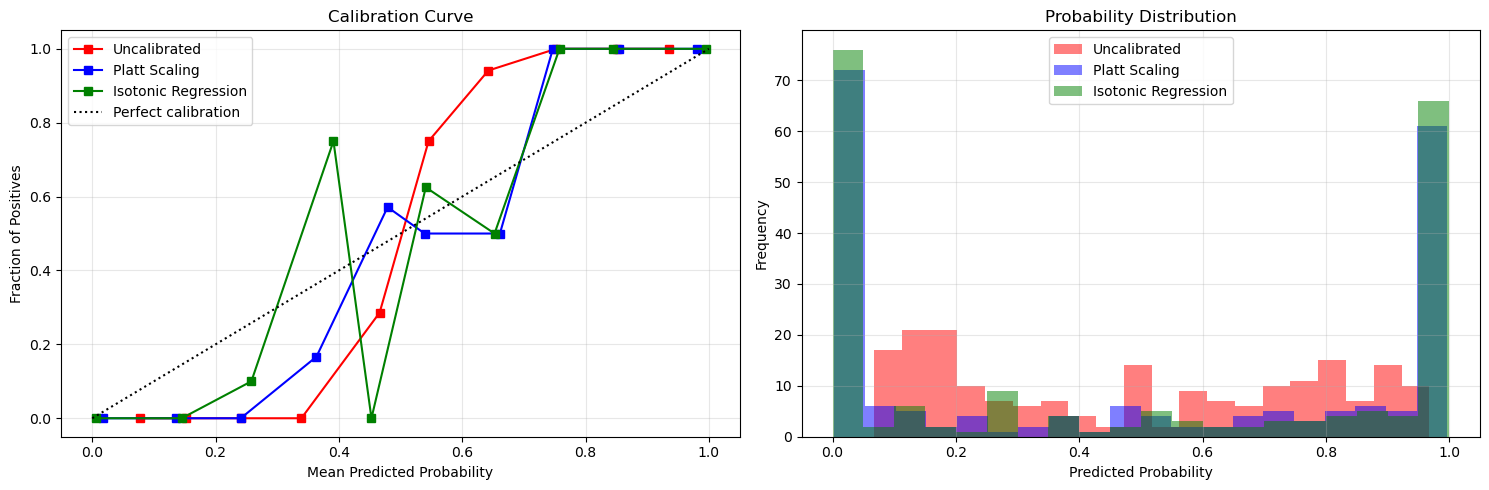

In [7]:
# Create calibration plots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Calibration curve
fraction_of_positives, mean_predicted_value = calibration_curve(
    y_test, rf_probs_uncalibrated, n_bins=10
)
axes[0].plot(mean_predicted_value, fraction_of_positives, "s-", 
             label="Uncalibrated", color='red')

fraction_of_positives, mean_predicted_value = calibration_curve(
    y_test, rf_probs_platt, n_bins=10
)
axes[0].plot(mean_predicted_value, fraction_of_positives, "s-", 
             label="Platt Scaling", color='blue')

fraction_of_positives, mean_predicted_value = calibration_curve(
    y_test, rf_probs_isotonic, n_bins=10
)
axes[0].plot(mean_predicted_value, fraction_of_positives, "s-", 
             label="Isotonic Regression", color='green')

axes[0].plot([0, 1], [0, 1], "k:", label="Perfect calibration")
axes[0].set_xlabel("Mean Predicted Probability")
axes[0].set_ylabel("Fraction of Positives")
axes[0].set_title("Calibration Curve")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Probability distribution
axes[1].hist(rf_probs_uncalibrated, bins=20, alpha=0.5, 
             label="Uncalibrated", color='red')
axes[1].hist(rf_probs_platt, bins=20, alpha=0.5, 
             label="Platt Scaling", color='blue')
axes[1].hist(rf_probs_isotonic, bins=20, alpha=0.5, 
             label="Isotonic Regression", color='green')
axes[1].set_xlabel("Predicted Probability")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Probability Distribution")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Base (max_depth=10) Performance:
  Brier Score: 0.045476  Log Loss: 0.191636
Platt Scaling Performance:
  Brier Score: 0.032760  Log Loss: 0.120919
Isotonic Regression Performance:
  Brier Score: 0.032984  Log Loss: 0.111390


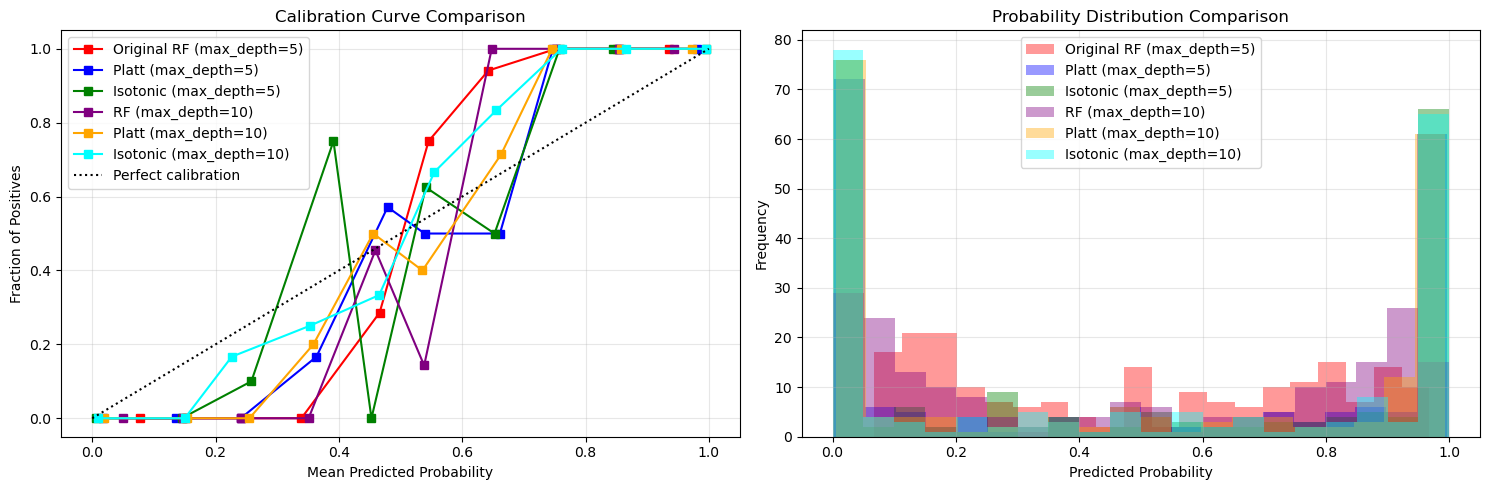

In [9]:
# Create a new base classifier with max_depth=10
base_clf = RandomForestClassifier(
    n_estimators=100, 
    random_state=42, 
    max_depth=10
)
base_clf.fit(X_train, y_train)

# Create calibrated versions using the new base classifier
clf_platt = CalibratedClassifierCV(
    base_clf, 
    method='sigmoid', 
    cv=3
)
clf_platt.fit(X_train, y_train)

clf_isotonic = CalibratedClassifierCV(
    base_clf, 
    method='isotonic', 
    cv=3
)
clf_isotonic.fit(X_train, y_train)

# Evaluate calibrated models and compare with the new base_clf
base_probs = base_clf.predict_proba(X_test)[:, 1]
platt_probs = clf_platt.predict_proba(X_test)[:, 1]
iso_probs = clf_isotonic.predict_proba(X_test)[:, 1]

# Compute metrics
base_brier = brier_score_loss(y_test, base_probs)
base_logloss = log_loss(y_test, base_probs)
platt_brier = brier_score_loss(y_test, platt_probs)
platt_logloss = log_loss(y_test, platt_probs)
iso_brier = brier_score_loss(y_test, iso_probs)
iso_logloss = log_loss(y_test, iso_probs)

print("Base (max_depth=10) Performance:")
print(f"  Brier Score: {base_brier:.6f}  Log Loss: {base_logloss:.6f}")
print("Platt Scaling Performance:")
print(f"  Brier Score: {platt_brier:.6f}  Log Loss: {platt_logloss:.6f}")
print("Isotonic Regression Performance:")
print(f"  Brier Score: {iso_brier:.6f}  Log Loss: {iso_logloss:.6f}")

# Create new calibration plots comparing all models
fig_new, axes_new = plt.subplots(1, 2, figsize=(15, 5))

# Plot calibration curves for all models
models = [
    (rf_probs_uncalibrated, "Original RF (max_depth=5)", "red"),
    (rf_probs_platt, "Platt (max_depth=5)", "blue"),
    (rf_probs_isotonic, "Isotonic (max_depth=5)", "green"),
    (base_probs, "RF (max_depth=10)", "purple"),
    (platt_probs, "Platt (max_depth=10)", "orange"),
    (iso_probs, "Isotonic (max_depth=10)", "cyan")
]

for probs, label, color in models:
    frac, mean_pred = calibration_curve(y_test, probs, n_bins=10)
    axes_new[0].plot(mean_pred, frac, "s-", label=label, color=color)

axes_new[0].plot([0, 1], [0, 1], "k:", label="Perfect calibration")
axes_new[0].set_xlabel("Mean Predicted Probability")
axes_new[0].set_ylabel("Fraction of Positives")
axes_new[0].set_title("Calibration Curve Comparison")
axes_new[0].legend()
axes_new[0].grid(True, alpha=0.3)

# Plot probability distributions
for probs, label, color in models:
    axes_new[1].hist(probs, bins=20, alpha=0.4, label=label, color=color)

axes_new[1].set_xlabel("Predicted Probability")
axes_new[1].set_ylabel("Frequency")
axes_new[1].set_title("Probability Distribution Comparison")
axes_new[1].legend()
axes_new[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Evaluate calibrated classifiers
platt_probs = clf_platt.predict_proba(X_test)[:, 1]
isotonic_probs = clf_isotonic.predict_proba(X_test)[:, 1]

# Calculate additional calibration metrics

# Calculate metrics for all methods
results = {
    'Base Model (max_depth=10)': {
        'Brier Score': brier_score_loss(y_test, base_probs),
        'Log Loss': log_loss(y_test, base_probs),
        'ROC AUC': roc_auc_score(y_test, base_probs),
        'Accuracy': accuracy_score(y_test, (base_probs > 0.5).astype(int)),
        'Precision': precision_score(y_test, (base_probs > 0.5).astype(int)),
        'Recall': recall_score(y_test, (base_probs > 0.5).astype(int)),
        'F1 Score': f1_score(y_test, (base_probs > 0.5).astype(int))
    },
    'Platt Scaling': {
        'Brier Score': brier_score_loss(y_test, platt_probs),
        'Log Loss': log_loss(y_test, platt_probs),
        'ROC AUC': roc_auc_score(y_test, platt_probs),
        'Accuracy': accuracy_score(y_test, (platt_probs > 0.5).astype(int)),
        'Precision': precision_score(y_test, (platt_probs > 0.5).astype(int)),
        'Recall': recall_score(y_test, (platt_probs > 0.5).astype(int)),
        'F1 Score': f1_score(y_test, (platt_probs > 0.5).astype(int))
    },
    'Isotonic Regression': {
        'Brier Score': brier_score_loss(y_test, isotonic_probs),
        'Log Loss': log_loss(y_test, isotonic_probs),
        'ROC AUC': roc_auc_score(y_test, isotonic_probs),
        'Accuracy': accuracy_score(y_test, (isotonic_probs > 0.5).astype(int)),
        'Precision': precision_score(y_test, (isotonic_probs > 0.5).astype(int)),
        'Recall': recall_score(y_test, (isotonic_probs > 0.5).astype(int)),
        'F1 Score': f1_score(y_test, (isotonic_probs > 0.5).astype(int))
    }
}

# Display comprehensive results table
print("\nComprehensive Calibration Results:")
print("=" * 90)
print(f"{'Method':<20} {'Brier':<8} {'LogLoss':<8} {'ROC AUC':<8} {'Acc':<6} {'Prec':<6} {'Rec':<6} {'F1':<6}")
print("=" * 90)
for method, metrics in results.items():
    print(f"{method:<20} {metrics['Brier Score']:<8.4f} {metrics['Log Loss']:<8.4f} "
          f"{metrics['ROC AUC']:<8.4f} {metrics['Accuracy']:<6.3f} {metrics['Precision']:<6.3f} "
          f"{metrics['Recall']:<6.3f} {metrics['F1 Score']:<6.3f}")

# Calculate calibration reliability metrics
def expected_calibration_error(y_true, y_prob, n_bins=10):
    """Calculate Expected Calibration Error (ECE)"""
    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]
    
    ece = 0
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        in_bin = (y_prob > bin_lower) & (y_prob <= bin_upper)
        prop_in_bin = in_bin.mean()
        
        if prop_in_bin > 0:
            accuracy_in_bin = y_true[in_bin].mean()
            avg_confidence_in_bin = y_prob[in_bin].mean()
            ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin
    
    return ece

# Calculate ECE for each method
print("\nExpected Calibration Error (ECE):")
print("-" * 40)
ece_base = expected_calibration_error(y_test, base_probs)
ece_platt = expected_calibration_error(y_test, platt_probs)
ece_isotonic = expected_calibration_error(y_test, isotonic_probs)

print(f"Base Model (max_depth=10): {ece_base:.4f}")
print(f"Platt Scaling:             {ece_platt:.4f}")
print(f"Isotonic Regression:       {ece_isotonic:.4f}")

# Identify best performing method for each metric
print("\nBest Method by Metric:")
print("-" * 30)
metrics_to_check = ['Brier Score', 'Log Loss', 'ROC AUC', 'F1 Score']
for metric in metrics_to_check:
    if metric in ['ROC AUC', 'F1 Score']:
        best_method = max(results.keys(), key=lambda x: results[x][metric])
        best_value = results[best_method][metric]
    else:
        best_method = min(results.keys(), key=lambda x: results[x][metric])
        best_value = results[best_method][metric]
    print(f"{metric:<12}: {best_method} ({best_value:.4f})")


Comprehensive Calibration Results:
Method               Brier    LogLoss  ROC AUC  Acc    Prec   Rec    F1    
Base Model (max_depth=10) 0.0455   0.1916   0.9963   0.945  0.938  0.948  0.943 
Platt Scaling        0.0328   0.1209   0.9954   0.950  0.948  0.948  0.948 
Isotonic Regression  0.0330   0.1114   0.9956   0.960  0.968  0.948  0.958 

Expected Calibration Error (ECE):
----------------------------------------
Base Model (max_depth=10): 0.1291
Platt Scaling:             0.0501
Isotonic Regression:       0.0380

Best Method by Metric:
------------------------------
Brier Score : Platt Scaling (0.0328)
Log Loss    : Isotonic Regression (0.1114)
ROC AUC     : Base Model (max_depth=10) (0.9963)
F1 Score    : Isotonic Regression (0.9579)
